This project provides a detailed explanation of the steps involved in building a machine learning pipeline for predicting audience ratings for movies, using the XGBRegressor model, data preprocessing, and evaluation. The entire process is broken down into the following sections: Data Cleaning, Feature Engineering, Model Building, Pipeline Explanation, and Model Evaluation.

# **Dataset: Rotten_Tomatoes_Movies3**
The dataset contains information about movies with a total of 16,639 rows and 16 columns. Each row represents a movie and includes various features such as movie title, genre, ratings, directors, critics' consensus, audience rating, and more.


In [437]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [438]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [439]:
!pip install pywsd

### **import libaries**

In [440]:
import pandas as pd
import pickle
import re
import seaborn as sns
from xgboost import XGBRegressor
import nltk
nltk.download('averaged_perceptron_tagger_eng') # Download the missing resource
nltk.download('stopwords') # Download the stopwords dataset
nltk.download('wordnet') # Download the wordnet dataset
nltk.download('punkt_tab')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

from pywsd.utils import lemmatize_sentence # This should now work
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

import warnings; warnings.simplefilter('ignore')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [441]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Data Import and Initial **Exploration**

In [442]:
final_df = pd.read_csv("/content/drive/MyDrive/Zoho/Rotten_Tomatoes_Movies3.csv")

In [443]:
final_df.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",12-02-2010,29-06-2010,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",30-04-2010,19-10-2010,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",05-10-1979,27-08-1997,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",13-04-1957,06-03-2001,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",01-01-1954,20-05-2003,127.0,Disney,Fresh,89,27,74.0


# Data Cleaning and **Preprocessing**

In [471]:
#cleaning function to remove unnecessary empty lines and apply stopwords, lemmatizing and stemming
def data_cleaning(only_text):

    only_text = only_text.astype(str).apply(lambda x : x.replace('\n','')) #removing new line
    only_text = only_text.apply(lambda x : x.replace('\t','')) # removing new tab
    only_text = only_text.apply(lambda x : ' '.join([word for word in x.split() if word not in (stop)])) #remove stop words
    only_text = only_text.apply(lambda x : " ".join(lemmatize_sentence(x))) #brininging words to root using lemmatization
    only_text = only_text.apply(lambda x : "".join([stemmer.stem(y) for y in x])) # Stem every word.
    return only_text

# Data Transformation and Feature **Engineering**

In [445]:
final_df['Rating_words'] = final_df['rating'].str.split("\s+\(").str[1]
final_df['Rating_words'] = final_df.Rating_words.astype(str)
final_df['Rating_words'] = final_df.Rating_words.str.replace('[^a-z \n]',"")
final_df['Rating_words'] = data_cleaning(final_df.Rating_words) # Replace stop_words_removal with data_cleaning
final_df['Rating_words'] = final_df.Rating_words.str.replace('nan','')
# final_df['Rating_words'] = final_df.Rating_words.str.strip()
# final_df['Rating_words'] = final_df.Rating_words.str.replace(' ','_')

final_df['rating'] = final_df['rating'].str.split("\s+\(").str[0]
final_df['rating'] = final_df.rating.replace("nr"," ")
final_df['rating'] = final_df.rating.str.strip()

# Data **Visualization**

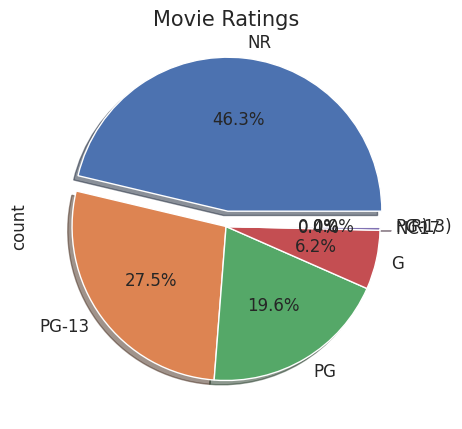

<Figure size 640x480 with 0 Axes>

In [446]:
import matplotlib.pyplot as plt

rating = final_df['rating'].value_counts().sort_values(ascending=False)
# Get the number of categories in the pie chart after slicing with [1:]
num_categories = len(rating[1:])
# Create an explode tuple with the correct length, emphasizing the first and last slices
explode = [0.1] + [0] * (num_categories - 2) + [0.1]
rating[1:].plot(kind="pie", explode=explode, figsize=(9, 5), fontsize=12, autopct='%1.1f%%', shadow=True)
plt.title("Movie Ratings", fontsize=15)
plt.show()
plt.savefig("Ratings")

In [447]:
final_df['directors'] = final_df.directors.str.replace('[^a-z \n]',"")
final_df['directors'] = final_df['directors'].str.split(',').str[0]
final_df['directors'] = final_df['directors'].fillna(" ")
final_df['directors'] = final_df.directors.str.strip()
final_df['directors'] = final_df.directors.str.replace(' ','_')

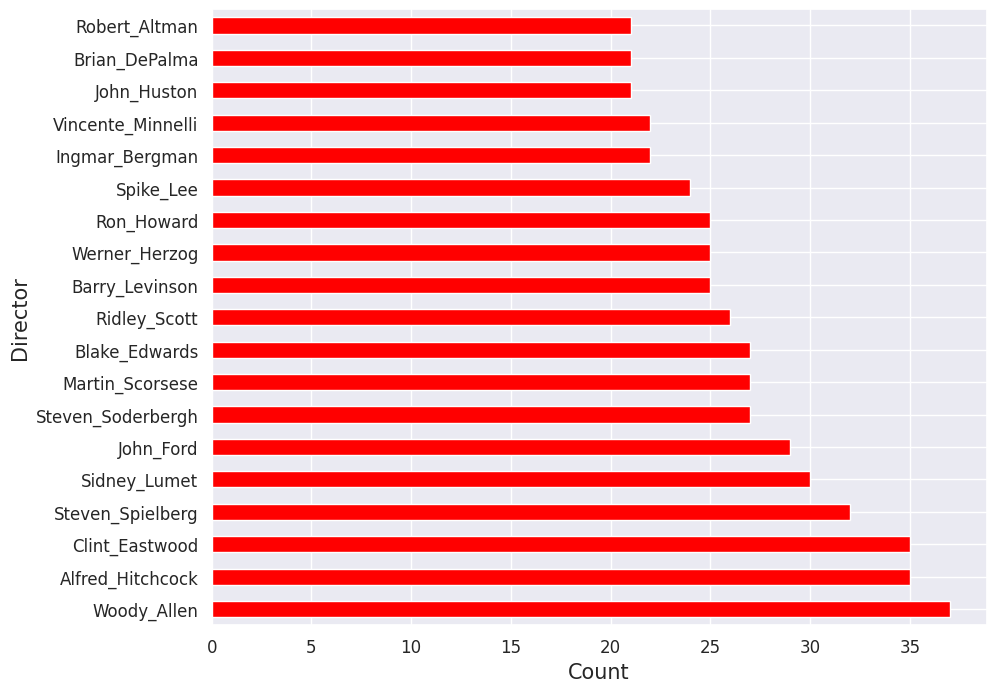

In [448]:
directors = final_df.groupby(['directors'])['movie_title'].nunique().sort_values(ascending=False)
directors[1:20].plot(kind="barh", figsize = (10,8), fontsize = 12,color="red")
plt.xlabel("Count", fontsize = 15)
plt.ylabel("Director", fontsize = 15)
#plt.title("Top 20 Movie Directors", fontsize = 15)
plt.savefig("MovieDirectors")

In [463]:
final_df['runtime_in_minutes'] = final_df['runtime_in_minutes'].replace("", np.NaN)  # Handle empty strings
final_df['runtime_in_minutes'] = final_df['runtime_in_minutes'].fillna(0)  # Replace NaNs with 0
final_df['runtime_in_minutes'] = final_df['runtime_in_minutes'].astype(float)  # Convert to float

In [464]:
final_df.loc[(final_df['runtime_in_minutes'] > 10) & (final_df['runtime_in_minutes'] < 90), 'runtime_brackets'] = 'short_till90'
final_df.loc[(final_df['runtime_in_minutes'] >= 90) & (final_df['runtime_in_minutes'] < 120), 'runtime_brackets'] = 'conventional_90_120'
final_df.loc[(final_df['runtime_in_minutes'] >= 120) & (final_df['runtime_in_minutes'] < 180), 'runtime_brackets'] = 'lengthy_120_180'
final_df.loc[(final_df['runtime_in_minutes'] >= 180) & (final_df['runtime_in_minutes'] < 800), 'runtime_brackets'] = 'super_lengthy_180_800'

final_df.loc[(final_df.runtime_brackets == 0), 'runtime_brackets'] = ' '

final_df['runtime_brackets'] = final_df.runtime_brackets.fillna(" ")

In [465]:
df = final_df[final_df['runtime_brackets']!=' ']
df.shape

(16469, 20)

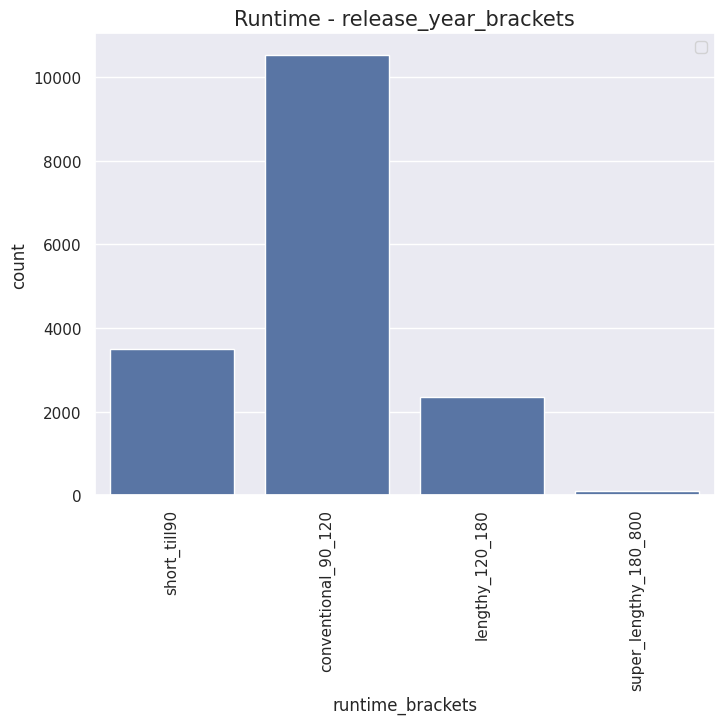

In [466]:
%matplotlib inline
sns.set(style="darkgrid")
a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.countplot(x='runtime_brackets', hue="release_year_brackets", data=df)
plt.xticks(rotation=90)
plt.title("Runtime - release_year_brackets", fontsize = 15)
plt.legend(loc='upper right')
plt.show()

In [472]:
final_df['genre'] = data_cleaning(final_df.genre) # Replace stop_words_removal with data_cleaning
final_df['genre'] = final_df.genre.str.replace('[^a-z \n]',"")
final_df['Genre_1'] = final_df.genre.str.split(' ').str[0] #+ ' ' + final_df.Genre.str.split(' ').str[1]
final_df['Genre_2'] = final_df.genre.str.split(' ').str[1] #+ ' ' + final_df.Genre.str.split(' ').str[1]
final_df['Genre_2'] = final_df.Genre_2.fillna(" ")
final_df['Genre_3'] = final_df.genre.str.split(' ').str[2] #+ ' ' + final_df.Genre.str.split(' ').str[1]
final_df['Genre_3'] = final_df.Genre_3.fillna(" ")
final_df['Genre_cleaned'] = final_df.Genre_1 + ' ' + final_df.Genre_2 + ' ' +final_df.Genre_3
final_df['Genre_cleaned'] = final_df.Genre_cleaned.str.strip()
final_df['Genre_cleaned'] =  final_df.Genre_cleaned.str.replace(' ','_')

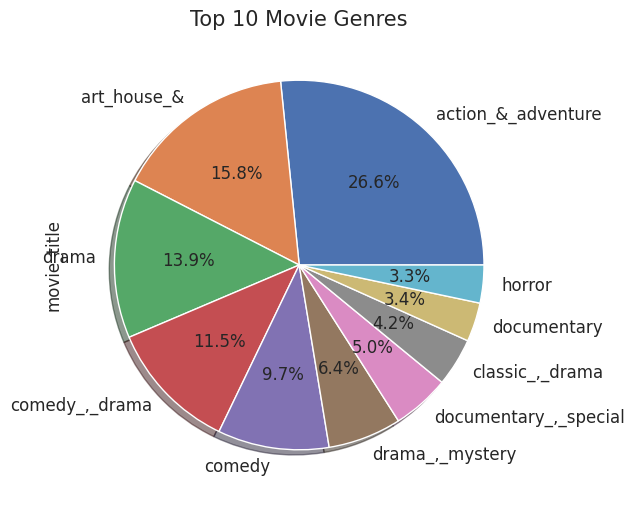

In [473]:
genre = final_df.groupby(['Genre_cleaned'])['movie_title'].nunique().sort_values(ascending=False)
genre[:10].plot(kind="pie", figsize = (9,6), fontsize = 12,autopct='%1.1f%%', shadow=True)
plt.title("Top 10 Movie Genres", fontsize = 15)
plt.savefig("Genres")

# Feature **Encoding**

In [474]:
X = final_df.drop('audience_rating', axis=1)
y = final_df.audience_rating
X['rating_encoded'] = X['rating'].astype('category').cat.codes
X['tomatometer_status_encoded'] = X['tomatometer_status'].astype('category').cat.codes
X = X.drop(['rating','tomatometer_status'], axis=1)

In [475]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [476]:
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and
                        X_train_full[cname].dtype == "object"]

numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]


In [477]:
categorical_cols

['Rating_words', 'release_year_brackets', 'runtime_brackets', 'Genre_2']

In [478]:
my_cols = categorical_cols + numerical_cols + ['rating_encoded', 'tomatometer_status_encoded']

In [479]:
my_cols

['Rating_words',
 'release_year_brackets',
 'runtime_brackets',
 'Genre_2',
 'runtime_in_minutes',
 'tomatometer_rating',
 'tomatometer_count',
 'release_year',
 'rating_encoded',
 'tomatometer_status_encoded']

In [480]:
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [481]:
import numpy as np
y_train = y_train.replace([np.inf, -np.inf], np.nan).dropna()
y_valid = y_valid.replace([np.inf, -np.inf], np.nan).dropna()
X_train = X_train.loc[y_train.index]  # Ensure X_train aligns with the cleaned y_train
X_valid = X_valid.loc[y_valid.index]

In [482]:
y_train = pd.cut(y_train, bins=4, labels=[0, 1, 2, 3]).astype(int)
y_valid = pd.cut(y_valid, bins=4, labels=[0, 1, 2, 3]).astype(int)

In [483]:
numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [484]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [485]:
from sklearn.preprocessing import FunctionTransformer

# Wrap XGBRegressor with FunctionTransformer
model = FunctionTransformer(lambda x: XGBRegressor())


In [486]:
# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

In [487]:
X_train

,Rating_words,release_year_brackets,runtime_brackets,Genre_2,runtime_in_minutes,tomatometer_rating,tomatometer_count,release_year,rating_encoded,tomatometer_status_encoded
4414,,,conventional_90_120,house,114.0,38,55,0,4,2
581,,,short_till90,&,80.0,88,8,0,2,1
2916,,,conventional_90_120,house,94.0,64,11,0,2,1
3679,,,lengthy_120_180,",",155.0,93,71,0,6,0
4721,,,conventional_90_120,",",93.0,91,32,0,2,1
...,...,...,...,...,...,...,...,...,...,...
9225,,,lengthy_120_180,",",124.0,82,91,0,4,0
13123,,,conventional_90_120,",",90.0,100,8,0,2,1
9845,,,lengthy_120_180,&,140.0,91,249,0,4,0
10799,,,short_till90,",",87.0,47,17,0,2,2


In [488]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['runtime_in_minutes',
                                                   'tomatometer_rating',
                                                   'tomatometer_count',
                                                   'release_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Rating_words',
                                                   'release_year_brackets',
                                                   'runtime_brackets',
                                                   'Genre_2'])])),
                ('model',
                 FunctionTransformer(func=<function <lambda> at 0x7f7be96efac0>))])

In [489]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.1, objective='multi:softmax', num_class=4)

In [490]:
from xgboost.callback import EarlyStopping
early_stopping = EarlyStopping(rounds=20, save_best=True)

In [491]:
# Preprocess training and validation data
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

In [492]:
!pip install xgboost==2.0.3



In [493]:
# Convert data to DMatrix format for XGBoost
from xgboost import XGBRegressor, DMatrix, train
dtrain = DMatrix(X_train_preprocessed, label=y_train)
dvalid = DMatrix(X_valid_preprocessed, label=y_valid)

In [494]:
# Set parameters for XGBoost
params = {
    'objective': 'multi:softmax',
    'num_class': 4,  # Assuming 4 classes in the target
    'eval_metric': 'mlogloss',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8
}

In [495]:
# Watchlist for early stopping
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [496]:
model = train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, evals=watchlist, verbose_eval=False)

In [497]:
# Use pipeline for predictions
predictions = model.predict(dvalid)
predictions

array([1., 2., 2., ..., 1., 2., 2.], dtype=float32)

In [498]:
bin_labels = [0, 1, 2, 3]
rating_bins = [0,1, 2, 3]  # Example rating range [1, 2, 3, 4, 5] (adjust according to your data)
predicted_ratings = [rating_bins[label] for label in predictions.astype(int)]

# Model Evaluation and **Predictions**
low rating is 1

medium rating is 2

high ratin is 3

In [499]:
predictions_df = pd.DataFrame({
    'Movie Name': X_valid_full.loc[y_valid.index, 'movie_title'],  # Ensure it matches the cleaned index
    'Predicted Audience Ratings': predicted_ratings
})

# Display the DataFrame
result=pd.DataFrame(predictions_df)
result.head(20)

,Movie Name,Predicted Audience Ratings
5101,The Delta Force,1
3374,Big Eden,2
16292,Wide Awake,2
12955,Spring Forward,3
14459,The Legend of Hercules,1
5897,Facing the Giants,1
15450,Transformer,3
5813,Everybody's Famous!,2
142,And God Created Woman,1
2618,Analyze This,2


In [500]:
# Calculate and print mean absolute error
mae = mean_absolute_error(y_valid, predictions)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.47985348105430603
